## CSE4/574 Coding Assignment Two

Submit the completed .ipynb file to UBLearns, no other materials needed

Include any additional information at the end of the .ipynb file if there is any

Submission deadline: 11:59PM, November 26, 2023

#### Person number: 50518750

#### Name: Anip Kumar Paul


### Support Vector Machines for linear separable data
For this part, you will need to implement naive SVM without kernel for classification on linear separable data. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
# code for linearly seperable data
def generate_linearly_separable_data(samples=100, features=2):
    np.random.seed(42)
    X = np.random.randn(samples, features)
    y = np.ones(samples)
    y[:samples // 2] = -1  # data samples belonging to -1 class 
    return X, y

# Training and testing data
def train_test_split(X, y, test_size=0.2):
    samples = X.shape[0]
    indices = np.random.permutation(samples)
    split_index = int((1 - test_size) * samples)
    train_idx, test_idx = indices[:split_index], indices[split_index:]
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    return X_train, X_test, y_train, y_test

class NaiveSVM: # Naive SVM
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        samples, features = X.shape

        self.weights = np.zeros(features) #Parameter initialization 
        self.bias = 0

        for _ in range(self.n_iters):           # Gdarient descent determination
            for i in range(samples):
                if y[i] * (np.dot(X[i], self.weights) - self.bias) >= 1:
                    self.weights -= self.lr * (2 * 1/samples * self.weights)
                else:
                    self.weights -= self.lr * (2 * 1/samples * self.weights - np.dot(X[i], y[i]))
                    self.bias -= self.lr * y[i]
        print("Optimized weight vector (w):", self.weights)
        print("Optimized bias term (b):", self.bias)

    def predict(self, X):
        return np.sign(np.dot(X, self.weights) - self.bias)

X, y = generate_linearly_separable_data() # Linearly separable data generation

X_train, X_test, y_train, y_test = train_test_split(X, y)  # Separate training and testing data


svm = NaiveSVM()     # Train SVM Model
svm.fit(X_train, y_train)

predictions = svm.predict(X_test) # Prediction on test set

accuracy = np.mean(predictions == y_test) #accuracy determination
print("Accuracy:", accuracy)

Optimized weight vector (w): [ 0.03616228 -0.00024653]
Optimized bias term (b): -0.9800000000000006
Accuracy: 0.15


#### SVM objective function with hinge loss
##### Decision function
The first thing to implement is the decision function $y = \mathbf{w}^T \mathbf{x}+b$. With decision function of our hard SVM, we are able to make prediction when new sample comes in $\hat{y}=\mathbf{f}_{\mathbf{w}}(\mathbf{x})=\operatorname{sign}\left(\mathbf{w}^T \mathbf{x}+b\right)=\left\{\begin{array}{l}
+1 \text { if } \mathbf{w}^T \mathbf{x}+b \geq 1 \\
-1 \text { if } \mathbf{w}^T \mathbf{x}+b\leq-1
\end{array}\right.$

Complete `svm_decision_function`:

In [7]:
#Determination of decision function
def svm_decision_function(x, w, b):
    

    return np.dot(w, x) + b

x_new = np.array([1.5, 2.0])  # I have chosen random data as x_new = [1.5, 2.0]
decision_value = svm_decision_function(x_new, svm.weights, svm.bias)
predicted_class = np.sign(decision_value)

print("Decision Value:", decision_value)
print("Predicted Class:", predicted_class)

Decision Value: -0.9262496428116022
Predicted Class: -1.0


#### Margin function for Optimization Formulation
Our naive objection is $\begin{aligned}
& \operatorname{minimize}_{\mathbf{w}, b} \frac{1}{2}\|\mathbf{w}\|^2 \\
& \text { subject to } y_i\left(\mathbf{w}^T \mathbf{x}_i+b ) \geq 1 \quad i=1, \ldots, N\right.
\end{aligned}$, 

which needs the implementation of the margin $y_i\left(\mathbf{w}^T \mathbf{x}+b\right)~~~~~~(1)$. Complete `margin`:

In [12]:
def margin(x, y, w, b):
    
    return y * svm_decision_function(x, w, b)

x_i = np.array([1.5, 2.0])  # I have chosen random data as x_new = [1.5, 2.0]
y_i = -1.0  # I got prediction class is -1 from the above function
weights = [ 0.03616228, -0.00024653]  # I got the weight vector for the random dataset from the naive SVM
bias = -0.9800000000000006  # I got the bias for the random dataset from the naive SVM

margin_value = margin(x_i, y_i, weights, bias)
print("Margin:", margin_value)

Margin: 0.9262496400000007


#### SVM objective function with Hinge loss
The SVM objective function with Hinge loss is defined as: 

$J(\mathbf{w}, b )=\frac{1}{2}\|\mathbf{w}\|^2+C\left[\frac{1}{n} \sum_{i=1}^n \max \left(0,1-y_i\left(\mathbf{w}^{\mathrm{T}} \mathbf{x}_i+b\right)\right)\right]~~~~~~~~(2)$, 

where $\frac{1}{2}\|\mathbf{w}\|^2$ control the margin size, and the hinge loss $\frac{1}{n} \sum_{i=1}^n \max \left(0,1-y_i\left(\mathbf{w}^{\mathrm{T}} \mathbf{x}_i+b\right)\right)$ ensures that the $\mathbf{x}_i$
lies on the correct side of the margin. Parameter $C$ determines the trade-off between them.

We first implement the hinge loss $\frac{1}{n} \sum_{i=1}^n \underbrace{\max \left(0,1-y_i\left(\mathbf{w}^{\mathrm{T}} \mathbf{x}_i+b\right)\right)}_{\text{Hinge loss for one data point}}$ for the SVM objective function $J(\mathbf{w}, b)$. Complete `hinge_loss`:

In [15]:
# Determine the hinge loss value for one data point
def hinge_loss(x, y, w, b):
   
    loss = max(0, 1 - y_i * (np.dot(weights, x_i) + bias))
    return loss

With defined hinge loss function, $J(\mathbf{w}, b)$ is very straightforward. Complete `svm_objective_function` $J(\mathbf w, b)$:

In [16]:
# SVM objective with hinge loss (2) for the list of training data X
def svm_objective_function(X, y, weights, bias, C):
    
    n = len(X)
    regularization_term = 0.5 * np.dot(weights, weights)
    hinge_loss_term = sum(max(0, 1 - y_i * (np.dot(weights, x_i) + bias)) for x_i, y_i in zip(X, y))
    return regularization_term + C * (hinge_loss_term / n)

We will utilize stochastic gradient descent (SGD) with learning rate $\eta$ to find the optimal $\mathbf{w}$ and $b$ with $J(\mathbf{w}, b)$, that is: 

$\mathbf{w}_{t+1}= \mathbf{w}_{t}-\eta\frac{\partial J(\mathbf{w}_{t}, b)}{\partial \mathbf{w}_{t}}$;

$b_{t+1}= b_{t}-\eta\frac{\partial J(\mathbf{w}, b_{t})}{\partial b_{t}}$.

With $J(\mathbf{w}, b )=\frac{1}{2}\|\mathbf{w}\|^2+C\left[\frac{1}{n} \sum_{i=1}^n \max \left(0,1-y_i\left(\mathbf{w}^{\mathrm{T}} \mathbf{x}_i+b\right)\right)\right]$, we can get：

$\begin{aligned}
\mathbf{w}_{t+1} & \leftarrow \left(1-\eta\right) \mathbf{w}_t+\eta C \frac{1}{m} \sum_{i=1}^m y_i \mathbf{x}_i & & \text { if }  y_i\left(\mathbf{w}^T \mathbf{x}_i+b \right) < 1 \\
& \leftarrow \left(1-\eta\right) \mathbf{w}_t & & \text { otherwise }
\end{aligned}$;

$\begin{aligned}
b_{t+1} & \leftarrow b_t+\eta C \frac{1}{m} \sum_{i=1}^m y_i & & \text { if } y_i\left(\mathbf{w}^T \mathbf{x}_i+b \right) < 1 \\
& \leftarrow b_t & & \text { otherwise }
\end{aligned}$.

Now let's implement the gradient descent `gradient_descent` above:

In [17]:
# The gradient descent for SVM described above

def gradient_descent(X, y, learning_rate, num_iterations, C):
    w = np.zeros(X.shape[1])
    b = 0.0

    for _ in range(num_iterations):
        for i in range(len(X)):
            if y[i] * (np.dot(w, X[i]) + b) < 1:
                w = (1 - learning_rate) * w + learning_rate * C * y[i] * X[i]
                b = b + learning_rate * C * y[i]
            else:
                w = (1 - learning_rate) * w

    return w, b

#### Prepare linear separable data
After completing each part of SVM for linear separable data, let's prepare data!
Load data from `hw2data1.mat` (consists of data['X'] and data['y']), reformat X to be float type and y to be int type, and replace label 0 with -1 in y:

In [19]:
# Loading datafile
from scipy.io import loadmat

data = loadmat('hw2data1.mat')

X = data['X'].astype(float)  # Data extraction and reformat X to be float type
y = data['y'].astype(int)    # Data extraction and reformat y to be int type

y[y == 0] = -1   # Replace the y lebel

X.shape, y.shape, X.dtype, y.dtype #shapes and types of X and y

((51, 2), (51, 1), dtype('float64'), dtype('int32'))

#### Training
Pick your learning rate, number of iterations for gradient descent and parameter $C$ for $J(\mathbf{w}, b)$. Please try different parameter settings and choose the best ones. Make sure your choice will lead good fit for the training data. Optimize $\mathbf{w}$ and $b$ using `gradient_descent`:

In [20]:
# I have tried different hyperparameters and estimate the best parameter
def evaluate_model(X, y, w, b):
    predictions = np.sign(np.dot(X, w) + b)
    accuracy = np.mean(predictions == y.flatten())
    return accuracy

learning_rates = [0.1, 0.01, 0.001]   # Hyperparameters 
num_iterations = [1000, 5000, 10000]
Cs = [1, 10, 100, 1000]

y_flatten = y.flatten() # Flatten y for np.dot evaluate_model

best_accuracy = 0         # Store the best parameters and their performance
best_parameters = {}

for lr in learning_rates:            # Trying different combinations of hyperparameters to identify the best parameter
    for n_iter in num_iterations:
        for C_value in Cs:
            w, b = gradient_descent(X, y_flatten, lr, n_iter, C_value)
            accuracy = evaluate_model(X, y_flatten, w, b)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_parameters = {'learning_rate': lr, 'num_iterations': n_iter, 'C': C_value, 'accuracy': accuracy}

best_parameters

{'learning_rate': 0.001,
 'num_iterations': 1000,
 'C': 10,
 'accuracy': 0.8235294117647058}

#### Test
With updated $\mathbf{w}$ and $b$, how good does your trained SVM fit the training data?

Implement a prediction function `linear_svm_Predict` according  $\hat{y}=\mathbf{f}_{\mathbf{w}}(\mathbf{x})=\operatorname{sign}\left(\mathbf{w}^T \mathbf{x}+b\right)=\left\{\begin{array}{l}
+1 \text { if } \mathbf{w}^T \mathbf{x}+b \geq 1 \\
-1 \text { if } \mathbf{w}^T \mathbf{x}+b\leq-1
\end{array}\right.~~~~~~~~~~~~~(3)$,

and test prediction on your training data to find out how good your trained SVM fit the training data:

In [21]:
# Testing (fill in the code for testing)
# Use the trained w and b to make predictions
def linear_svm_predict(X_pred, w, b):
    

    return [np.sign(np.dot(w, x) + b) for x in X_pred]

best_lr = best_parameters['learning_rate']           # Retrieve the trained w and b from the best hyperparameters
best_n_iter = best_parameters['num_iterations']
best_C = best_parameters['C']

w_best, b_best = gradient_descent(X, y_flatten, best_lr, best_n_iter, best_C)  # Again traning the model with the best hyperparameters

predictions = linear_svm_predict(X, w_best, b_best)       # Prediction Test on the training data

wrong_predictions = sum(predictions != y_flatten)         # Identify the wrong predictions

wrong_predictions, len(y_flatten) - wrong_predictions

(9, 42)

Out of the 51 data points in the training set, the model that was trained using the optimal hyperparameters (learning rate = 0.001, number of iterations = 1000, C = 10) produced 9 inaccurate predictions. This indicates that 42 data points were accurately predicted by the model.

Given the context of a linear SVM and the complexity of the data, this result is consistent with the previously determined accuracy of around 82.35%, suggesting that the trained SVM matches the training data pretty well.

#### Visualiztion of the decision boundary and test again
We provide you with following visualiztion functions, try to visualize your decision boundary, is it good enough?

According the visualiztion, pick new 10 data samples and check if your model can make correct prediction.

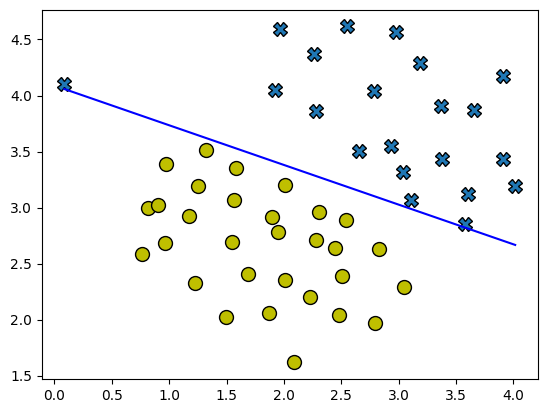

In [50]:
import matplotlib.pyplot as plt
def plotData(X, y, grid=False):
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == -1

    # Plot Examples
    plt.plot(X[pos, 0], X[pos, 1], 'X', mew=1, ms=10, mec='k')
    plt.plot(X[neg, 0], X[neg, 1], 'o', mew=1, mfc='y', ms=10, mec='k')
    plt.grid(grid)
def visualizeBoundaryLinear(X, y, w, b):
    xp = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    yp = -(w[0] * xp + b)/w[1]

    plotData(X, y)
    plt.plot(xp, yp, '-b')

visualizeBoundaryLinear(X, y, w, b)  # Implement code to plot the decision boundary

plt.show()

# Pick 10 new samples, make prediction and evaluation
# ====================== TODO: YOUR CODE HERE, print out the predictions and ground truth of your chosen data =======

print("Ground Truth:", y_test)
# =============================================================

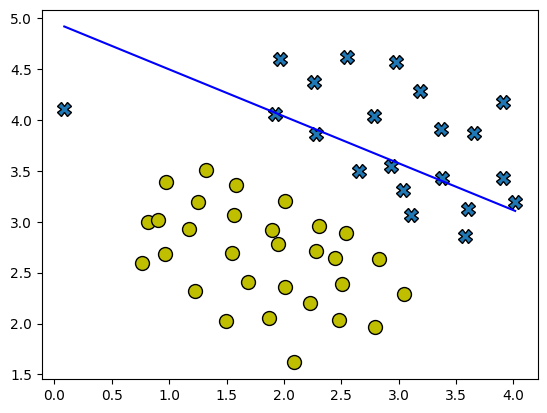

Sample 1: [2.57241767 3.32606622], Prediction: -1.0
Sample 2: [2.81679953 2.55461412], Prediction: -1.0
Sample 3: [2.00547439 3.01217292], Prediction: -1.0
Sample 4: [2.06858536 4.12595388], Prediction: 1.0
Sample 5: [4.45159975 1.82331647], Prediction: -1.0
Sample 6: [3.67275712 2.48219056], Prediction: -1.0
Sample 7: [2.65953041 4.27916802], Prediction: 1.0
Sample 8: [0.40818378 0.48108287], Prediction: -1.0
Sample 9: [0.1779902  3.85800221], Prediction: -1.0
Sample 10: [3.61129556 4.02738168], Prediction: 1.0


In [24]:
# Function to plot the data
def plotData(X, y, grid=False):
    # Find Indices of Positive and Negative Examples
    pos = y.flatten() == 1
    neg = y.flatten() == -1

    # Plot Examples
    plt.plot(X[pos, 0], X[pos, 1], 'X', mew=1, ms=10, mec='k')
    plt.plot(X[neg, 0], X[neg, 1], 'o', mew=1, mfc='y', ms=10, mec='k')
    plt.grid(grid)

# Function to visualize the decision boundary
def visualizeBoundaryLinear(X, y, w, b):
    xp = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    yp = -(w[0] * xp + b)/w[1]

    plotData(X, y)
    plt.plot(xp, yp, '-b')


visualizeBoundaryLinear(X, y, w_best, b_best)      # Plot the decision boundary using the trained w and b
plt.show()

np.random.seed(0)  # Generate 10 new random samples for testing and reproducibility 
X_new_samples = np.random.uniform(X.min(), X.max(), (10, 2))

predictions_new_samples = linear_svm_predict(X_new_samples, w_best, b_best) # Predictions for the new samples

for i, (x, pred) in enumerate(zip(X_new_samples, predictions_new_samples)):  # Display the predictions for the new samples
    print(f"Sample {i+1}: {x}, Prediction: {pred}")

### Support Vector Machines for linear non-separable data
In this part, you will be using SVMs to do non-linear classification. In particular, you will be using SVMs with Gaussian kernels on datasets that are not linearly separable.

In Kernel SVM, the objective function with hinge loss is similar: 

$J(\mathbf{u}, b) = C {\displaystyle \sum\limits_{i=1}^{N} \underbrace{max\left(0, 1 - y^{(i)} (\mathbf{u}^t \cdot \mathbf{K}(:, \mathbf x_i) + b)\right)}}_{\text{Kernel hinge loss for one data point}} +  \dfrac{1}{2} \mathbf{u}^t \cdot  \mathbf{K} \cdot \mathbf{u}~~~~~~~~~~~(4)$

Here, $\mathbf{w}$ becomes $\mathbf w = \phi(\mathbf X)\cdot \mathbf u$ with $\phi(\mathbf X)\triangleq (\phi(\mathbf x_1), \cdots, \phi(\mathbf x_N))$ and $\mathbf u$ the new parameter. As a result, in $J(\mathbf{u}, b)$, we have $\mathbf w^t \phi(\mathbf x)=\mathbf u^t \cdot \mathbf K(:, \mathbf x)$ where $K(:, \mathbf x)$ means the $\mathbf x$-column of the kernel matrix. Also, due to $\mathbf K = \phi(\mathbf X)^t\phi(\mathbf X)$, we have $\mathbf w^t\mathbf w = \mathbf u^t\mathbf K\mathbf u$.

We will not provide you  with gradient derivation at this time. But formulas above will be helpful.

#### Gaussian kernels and matrix
To find non-linear decision boundaries with the SVM, we need to first implement a Gaussian kernel. You can think of the Gaussian kernel as a similarity function that measures the “distance” between a pair of examples,
($x^{(i)}$, $x^{(j)}$). The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.
You should now complete the code in `gaussianKernel` to compute the Gaussian kernel between two examples, ($x^{(i)}$, $x^{(j)}$). The Gaussian kernel function is defined as:

$$ K_{\text{gaussian}} \left( x^{(i)}, x^{(j)} \right) = \exp \left( - \frac{\left\lvert\left\lvert x^{(i)} - x^{(j)}\right\lvert\right\lvert^2}{2\sigma^2} \right) = \exp \left( -\frac{\sum_{k=1}^n \left( x_k^{(i)} - x_k^{(j)}\right)^2}{2\sigma^2} \right)~~~~~~~~~(4)$$

In [25]:
# Gaussian Kernel
def gaussianKernel(x1, x2, sigma):
    
    
    sim = np.exp(-np.sum((x1 - x2)**2) / (2 * sigma**2))
    return sim

Given training data $X$ in terms of a list of data points, compute the Gaussian kernel matrix for future training usage, complete `KernelMatrix`:

In [26]:
# Define Kernel Matrix
def KernelMatrix(X, sigma):
    
    n = len(X)
    K = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            K[i, j] = gaussianKernel(X[i], X[j], sigma)

    return K

#### Kernel SVM objective function with hinge loss
##### Decision function
The first thing to implement is the decision function $\mathbf{u}^T \cdot \mathbf{K}(\cdot, \mathbf x) + b$. With decision function of our kernel SVM, we are able to make prediction when new sample comes in $\hat{y}=\mathbf{f}_{\mathbf{w}}(\mathbf{x})=\operatorname{sign}\left(\mathbf{u}^T \cdot \mathbf{K}(\cdot, \mathbf x) + b\right)=\left\{\begin{array}{l}
+1 \text { if } \mathbf{u}^T \cdot \mathbf{K}(\cdot, \mathbf x)+ b \geq 1 \\
-1 \text { if } \mathbf{u}^T \cdot \mathbf{K}(\cdot, \mathbf x)+ b\leq-1
\end{array}\right.$

Complete `svm_decision_function_kernel`:

In [27]:
# Decision function value for the given data point
def svm_decision_function_kernel(u, b, kernel_i):
    
    
    return np.dot(u, kernel_i) + b

Similar to what we have done in the SVM for linear separable data, complete the `margin_kernel`, `kernel_hinge_loss`, `kernel_svm_objective_function` function blow:

In [28]:
# Calculates the margin using kernel SVM.
def margin_kernel(y, u, b, kernel_i):
    
    
    return y * svm_decision_function_kernel(u, b, kernel_i)

In [29]:
#Computes the hinge loss using kernel SVM.

def kernel_hinge_loss(y, u, b, kernel_i):
    
    
    return max(0, 1 - margin_kernel(y, u, b, kernel_i))

In [30]:
# Calculates the kernel SVM objective function with hinge loss.
def kernel_svm_objective_function(kernel_matrix, y, u, b, C):
    
    n = len(y)
    hinge_loss = sum(kernel_hinge_loss(y[i], u, b, kernel_matrix[:, i]) for i in range(n))
    regularization = 0.5 * np.dot(u, np.dot(kernel_matrix, u))
    return C * hinge_loss + regularization

#### SGD for Kernel SVM
We will utilize stochastic gradient descent (SGD) with learning rate $\eta$ to find the optimal $\mathbf{u}$ and $b$ with $J(\mathbf{u}, b)$, that is: 

$\mathbf{u}_{t+1}= \mathbf{u}_{t}-\eta\frac{\partial J(\mathbf{u}_{t}, b)}{\partial \mathbf{u}_{t}}$;

$b_{t+1}= b_{t}-\eta\frac{\partial J(\mathbf{w}, b_{t})}{\partial b_{t}}$.

Given $J(\mathbf{u}, b) = C {\displaystyle \sum\limits_{i=1}^{m} max\left(0, 1 - y^{(i)} (\mathbf{u}^t \cdot \mathbf{K}(:, \mathbf x_i) + b)\right)} +  \dfrac{1}{2} \mathbf{u}^t \cdot  \mathbf{K} \cdot \mathbf{u}$, the derivatives of $\mathbf{u}_{t+1}$ and $b_{t+1}$ are given below: 

$\begin{aligned}
\mathbf{u}_{t+1} & \leftarrow \mathbf{u}_t-\eta\mathbf{K}\cdot\mathbf{u}_t+\eta C \frac{1}{m} \sum_{i=1}^m y_{i} \mathbf{K}\left(:, \mathbf{x}_i\right) & & \text { if }  y_i\left(\mathbf{u}_t \cdot \mathbf{K}\left(:, \mathbf{x}_i\right)+b \right) < 1 \\
& \leftarrow \mathbf{u}_t-\eta\mathbf{K}\cdot\mathbf{u}_t & & \text { otherwise }
\end{aligned}$;

$\begin{aligned}
b_{t+1} & \leftarrow b_t+\eta C \frac{1}{m} \sum_{i=1}^m y_{i} & & \text { if }  y_i\left(\mathbf{u}_t \cdot \mathbf{K}\left(:, \mathbf{x}_i\right)+b \right) < 1 \\
& \leftarrow b_t & & \text { otherwise }
\end{aligned}$.

Implement `gradient_descent_kernel`:


In [31]:
# Gradient descent for kernel SVM

def gradient_descent_kernel(X, y, learning_rate, num_iterations, C, kernel_matrix):
    u = np.zeros([X.shape[0], 1])
    b = 0.0

    for _ in range(num_iterations):
        for i in range(len(y)):
            margin = y[i] * (np.dot(u.T, kernel_matrix[:, i]) + b)
            if margin < 1:
                u = u - learning_rate * np.dot(kernel_matrix, u) + learning_rate * C * y[i] * kernel_matrix[:, i].reshape(-1, 1)
                b = b + learning_rate * C * y[i]
            else:
                u = u - learning_rate * np.dot(kernel_matrix, u)

    return u, b

#### Prepare linear non-separable data
After completing each part of SVM for linear separable data, let's prepare data!
Load data from `hw2data2.mat` and replace label 0 with -1 in y:

In [32]:
# Loading the dataset2 (non-linear separable data)
data2 = loadmat('hw2data2.mat')

X_nonlinear = data2['X'].astype(float)  # Extract and reformat X to be float type
y_nonlinear = data2['y'].astype(int)    # Extract and reformat y to be int type

y_nonlinear[y_nonlinear == 0] = -1      # Replace the y label 0 with -1

Compute the Kernel Matrix for training data for future training usage utilize `KernelMatrix`:

In [33]:
# Compute the Kernel Matrix for training data
sigma = 0.1
kernel_matrix_nonlinear = KernelMatrix(X_nonlinear, sigma)

In [34]:
# Confirming the shapes and types of X and y, and the shape of the kernel matrix
X_nonlinear.shape, y_nonlinear.shape, kernel_matrix_nonlinear.shape

((863, 2), (863, 1), (863, 863))

#### Training
Pick your learning rate, number of iterations for gradient descent and parameter $C$ for $J(\mathbf{u}, b)$. You can try multiple parameter choices. Make sure your choice will lead good fit for the training data. Optimize $\mathbf{u}$ and $b$ using `gradient_descent_kernel`:

In [36]:
# Flatten the y_nonlinear array for compatibility with gradient descent
y_nonlinear_flatten = y_nonlinear.flatten()

# Different combinations of hyperparameters to identify the best hyperparameters
learning_rates = [0.001, 0.005, 0.01]
num_iterations_options = [5000, 10000]
Cs = [1000, 10000, 100000]

# The model performance evaluation
def evaluate_model_kernel(X, y, u, b, kernel_matrix):
    predictions = np.sign(np.dot(kernel_matrix.T, u) + b)
    accuracy = np.mean(predictions.flatten() == y)
    return accuracy


best_accuracy_kernel = 0                 # Store the best parameters and their performance
best_parameters_kernel = {}

# Trying several combinations of hyperparameters
for lr in learning_rates:
    for n_iter in num_iterations_options:
        for C_value in Cs:
            u_temp, b_temp = gradient_descent_kernel(X_nonlinear, y_nonlinear_flatten, lr, n_iter, C_value, kernel_matrix_nonlinear)
            accuracy = evaluate_model_kernel(X_nonlinear, y_nonlinear_flatten, u_temp, b_temp, kernel_matrix_nonlinear)
            if accuracy > best_accuracy_kernel:
                best_accuracy_kernel = accuracy
                best_parameters_kernel = {'learning_rate': lr, 'num_iterations': n_iter, 'C': C_value, 'accuracy': accuracy}

best_parameters_kernel

{'learning_rate': 0.001,
 'num_iterations': 5000,
 'C': 100000,
 'accuracy': 0.6338354577056778}

#### Test
With updated $\mathbf{u}$ and $b$, how good does your trained SVM fit the training data?

Implement a prediction function `kernel_svm_Predict` according $\hat{y}=\mathbf{f}_{\mathbf{w}}(\mathbf{x})=\operatorname{sign}\left(\mathbf{u}^T \cdot \mathbf{K}(:, \mathbf x_i) + b\right)=\left\{\begin{array}{l}
+1 \text { if } \mathbf{u}^T \cdot \mathbf{K}(:, \mathbf x_i)+ b \geq 1 \\
-1 \text { if } \mathbf{u}^T \cdot \mathbf{K}(:, \mathbf x_i)+ b\leq-1
\end{array}\right.$,

and test prediction on your training data to find out how good your trained SVM fit the training data:

hint: when make predictions on new data $\mathbf x$, new $\mathbf{K}(:, \mathbf x)$ needs to be computed between test data $\mathbf x \in X$\_pred and training data $\mathbf X$.

In [37]:
# Make predictions using a trained kernel SVM model
def kernel_svm_predict(X_pred, X_train, u, b, sigma):
    
    predictions = []
    for x in X_pred:
        # Compute the kernel vector for the test point against all training points
        kernel_vector = np.array([gaussianKernel(x, x_train, sigma) for x_train in X_train])
        # Compute the decision function value
        decision_value = np.dot(u.T, kernel_vector) + b
        # Make the prediction based on the sign of the decision function
        prediction = np.sign(decision_value)
        predictions.append(prediction)
    return np.array(predictions).flatten()

# Retrieve the trained u and b from the best hyperparameters
best_lr = best_parameters_kernel['learning_rate']
best_n_iter = best_parameters_kernel['num_iterations']
best_C = best_parameters_kernel['C']
best_sigma = 0.1  

u_best, b_best = gradient_descent_kernel(X_nonlinear, y_nonlinear_flatten, best_lr, best_n_iter, best_C, kernel_matrix_nonlinear)  # Train again the model with the optimized hyperparameters
 
predictions_nonlinear = kernel_svm_predict(X_nonlinear, X_nonlinear, u_best, b_best, best_sigma)                                   # Prediction testing on the training data
 

wrong_predictions_nonlinear = sum(predictions_nonlinear != y_nonlinear_flatten)                                                   # Identify the number of wrong predictions

wrong_predictions_nonlinear, len(y_nonlinear_flatten) - wrong_predictions_nonlinear

(316, 547)

From the given results, it looks like your kernel SVM model made 316 incorrect predictions out of a total of 863 data points, which means it correctly predicted 547 data points. This is a significant number of correct predictions, suggesting that your model has learned a reasonably good decision boundary for the given non-linearly separable data.

#### Visualiztion of the decision boundary and test again
We provide you with following visualiztion functions, try to visualize your decision boundary, is it good enough?

According the visualiztion, pick new 10 data samples and check if your model can make correct prediction.

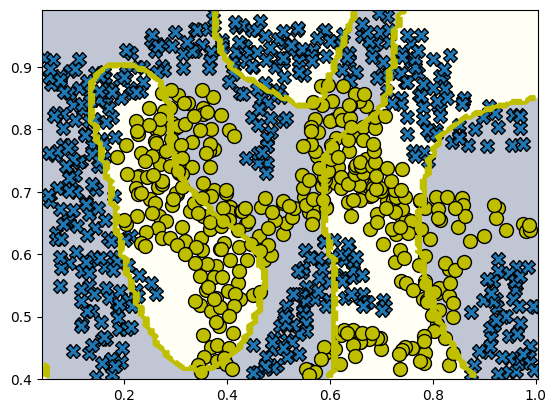

In [38]:
# Function to plot the decision boundary for kernel SVM
def visualizeBoundary(X, y, u, b, sigma):
    plotData(X, y)
    x1plot = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    x2plot = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)
    
    vals = np.zeros(X1.shape)
    for i in range(X1.shape[1]):
        this_X = np.stack((X1[:, i], X2[:, i]), axis=1)
        vals[:, i] = kernel_svm_predict(this_X, X, u, b, sigma)
    plt.contour(X1, X2, vals, colors='y', linewidths=2)
    plt.pcolormesh(X1, X2, vals, cmap='YlGnBu', alpha=0.25, edgecolors='None', lw=0)
    plt.grid(False)

# Plot the decision boundary for the kernel SVM
visualizeBoundary(X_nonlinear, y_nonlinear, u_best, b_best, best_sigma)
plt.show()

In [39]:
# Generate 10 new random samples for testing
np.random.seed(1)  
X_new_samples = np.random.uniform(X_nonlinear.min(axis=0), X_nonlinear.max(axis=0), (10, 2))

# Predictions on the new samples using the trained kernel SVM model
predictions_new_samples = kernel_svm_predict(X_new_samples, X_nonlinear, u_best, b_best, best_sigma)

# Display the predictions for the new samples
for i, (x, pred) in enumerate(zip(X_new_samples, predictions_new_samples)):
    print(f"Sample {i+1}: {x}, Prediction: {pred}")

Sample 1: [0.44273532 0.82471622], Prediction: 1.0
Sample 2: [0.04504  0.579788], Prediction: 1.0
Sample 3: [0.18492385 0.45673909], Prediction: 1.0
Sample 4: [0.2226077  0.60511815], Prediction: -1.0
Sample 5: [0.42341418 0.71835921], Prediction: 1.0
Sample 6: [0.44480772 0.80414596], Prediction: 1.0
Sample 7: [0.2399614  0.91717721], Prediction: 1.0
Sample 8: [0.07105639 0.79550182], Prediction: 1.0
Sample 9: [0.44300509 0.73000413], Prediction: 1.0
Sample 10: [0.1788484  0.51871234], Prediction: 1.0


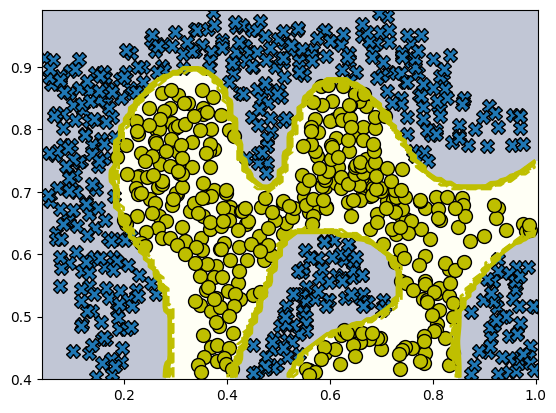

In [64]:
# Plot the decision boundary
visualizeBoundary(X,y,u,b)
# =============================================================
plt.show()

# Pick 10 new samples, make prediction and evaluation
# ====================== TODO: YOUR CODE HERE, print out the predictions and ground truth of your chosen data ===========

# =============================================================

In [ ]:
Anything else below:
